# EAGE 2020 abstract, Figures 3

Runtime and convergence of space-frequency vs space-Laplace

We use for it the SEG/EAGE 3-D Salt Model; see the notebook [github.com/empymod/emg3d-examples > 2a_SEG-EAGE_3D-Salt-Model.ipynb](https://github.com/empymod/emg3d-examples/blob/master/2a_SEG-EAGE_3D-Salt-Model.ipynb) to see 
how the model is calculated etc.

### References
- **Aminzadeh, F., Brac, J., and Kunz, T., 1997**, SEG/EAGE 3-D Salt and Overthrust Models, Society of Exploration Geophysicists, Tulsa, Oklahoma.

In [1]:
import emg3d
import joblib
import discretize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Load data

In [3]:
# Get resistivities if we already calculated them
res = joblib.load('../../emg3d-examples/data/SEG-EAGE/res-model.lzma')

# Get dimension
nx, ny, nz = res.shape

# Create corresponding mesh
mesh = discretize.TensorMesh([np.ones(nx)*20., np.ones(ny)*20., np.ones(nz)*20.], x0='00N')

# Forward modelling

## Survey parameters

In [4]:
src = [6400, 6600, 6500, 6500, -50, -50]  # source location
freq = 1.0                                # Frequency

## Initialize calculation mesh

In [5]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=6500, freq=freq, limits=[0, 13500], min_width=[5, 100])
hz_min, zdomain = emg3d.utils.get_domain(freq=freq, limits=[-4180, 0], min_width=[5, 20], fact_pos=40)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, 6500)
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, 6500)
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx, x0=-100, x1=0)
grid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
grid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128          0.00     13,482.75     55.13    182.61    1.02
   y    128          0.00     13,482.75     55.13    182.61    1.02
   z    128     -4,180.00     11,250.16     20.00    516.82    1.05

## Put the salt model onto the modelling mesh

In [6]:
# Interpolate original model to calculation grid
cres = emg3d.utils.grid2grid(mesh, res, grid, 'volume')

# Create model
model = emg3d.utils.Model(grid, cres)

# Set air resistivity
iz = np.argmin(np.abs(grid.vectorNz))
model.res_x[:, :, iz:] = 1e10

# Ensure at least top layer is water
model.res_x[:, :, iz] = 0.3

## $x-f$ domain; $s=i\omega=i2\pi f$

In [7]:
sfield = emg3d.utils.get_source_field(grid, src, freq, 0)
pfield, info_xf = emg3d.solve(grid, model, sfield, return_info=True, verb=-1)

:: emg3d :: 9.3e-07; 16; 0:02:38; CONVERGED


## $x-s$ domain (invoked by giving negative frequency); $s=2\pi f$

In [8]:
sfield = emg3d.utils.get_source_field(grid, src, -2*np.pi*freq, 0)
pfield, info_xs = emg3d.solve(grid, model, sfield, return_info=True, verb=-1)

:: emg3d :: 7.6e-07; 14; 0:01:52; CONVERGED


In [9]:
#emg3d.utils.data_write('runtime', ['info_xf', 'info_xs'], [info_xf, info_xs])
info_xf, info_xs = emg3d.utils.data_read('runtime', ['info_xf', 'info_xs'])

In [10]:
print(f"Mean f-domain :: {np.mean(np.diff(info_xf['runtime_at_cycle'])):4.1f}")
print(f"Mean s-domain :: {np.mean(np.diff(info_xs['runtime_at_cycle'])):4.1f}")
print(f"Speed-up      :: {info_xs['time']/info_xf['time']:5.2f}")

Mean f-domain ::  9.9
Mean s-domain ::  8.0
Speed-up      ::  0.71


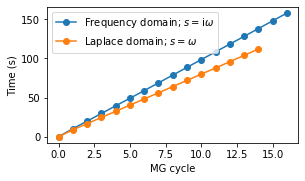

In [11]:
plt.figure(figsize=(4.5, 2.5))

plt.plot(info_xf['runtime_at_cycle'], 'o-', label=r'Frequency domain; $s=\mathrm{i}\omega$')
plt.plot(info_xs['runtime_at_cycle'], 'o-', label=r'Laplace domain; $s=\omega$')
plt.xlabel('MG cycle')
plt.ylabel('Time (s)')
plt.legend()

#plt.savefig('../figures/xf-vs-xs.pdf', bbox_inches='tight')
plt.show()

In [12]:
emg3d.Report(discretize)

--------------------------------------------------------------------------------
  Date: Mon Jan 06 15:07:40 2020 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.4 : numpy
             1.3.2 : scipy
            0.46.0 : numba
0.9.3.dev1+gc9e595e : emg3d
            7.10.2 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------